In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-01 23:08:43.013166: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 23:08:43.013195: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.1)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="gauss", threshold=0.5,
                                  noise_distribution="gauss", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:100096, :], y[:100096]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

scan_schedule = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in scan_schedule:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/41


2022-05-01 23:08:46.014539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-01 23:08:46.014581: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 23:08:46.014705: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-01 23:08:46.015710: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


391/391 [==============================] - 2s 3ms/step - loss: 0.6975 - accuracy: 0.5342 - auc: 0.5466 - val_loss: 0.6627 - val_accuracy: 0.6250 - val_auc: 0.6892
Epoch 2/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6603 - accuracy: 0.6035 - auc: 0.6454 - val_loss: 0.6198 - val_accuracy: 0.7240 - val_auc: 0.8094
Epoch 3/41
391/391 [==============================] - 1s 4ms/step - loss: 0.6210 - accuracy: 0.6639 - auc: 0.7275 - val_loss: 0.5676 - val_accuracy: 0.7866 - val_auc: 0.8744
Epoch 4/41
391/391 [==============================] - 2s 4ms/step - loss: 0.5746 - accuracy: 0.7166 - auc: 0.7939 - val_loss: 0.5061 - val_accuracy: 0.8266 - val_auc: 0.9133
Epoch 5/41
391/391 [==============================] - 2s 5ms/step - loss: 0.5256 - accuracy: 0.7575 - auc: 0.8403 - val_loss: 0.4414 - val_accuracy: 0.8582 - val_auc: 0.9396
Epoch 6/41
391/391 [==============================] - 2s 6ms/step - loss: 0.4756 - accuracy: 0.7900 - auc: 0.8745 - val_loss: 0.3791 - val_ac

391/391 [==============================] - 1s 2ms/step - loss: 0.4213 - accuracy: 0.8209 - auc: 0.8991 - val_loss: 0.3130 - val_accuracy: 0.8987 - val_auc: 0.9670
Epoch 6/41
391/391 [==============================] - 1s 2ms/step - loss: 0.3762 - accuracy: 0.8428 - auc: 0.9187 - val_loss: 0.2651 - val_accuracy: 0.9129 - val_auc: 0.9758
Epoch 7/41
391/391 [==============================] - 1s 2ms/step - loss: 0.3382 - accuracy: 0.8590 - auc: 0.9333 - val_loss: 0.2275 - val_accuracy: 0.9252 - val_auc: 0.9821
Epoch 8/41
391/391 [==============================] - 1s 2ms/step - loss: 0.3130 - accuracy: 0.8693 - auc: 0.9421 - val_loss: 0.1991 - val_accuracy: 0.9352 - val_auc: 0.9863
Epoch 9/41
391/391 [==============================] - 1s 2ms/step - loss: 0.2891 - accuracy: 0.8805 - auc: 0.9501 - val_loss: 0.1770 - val_accuracy: 0.9414 - val_auc: 0.9892
Epoch 10/41
391/391 [==============================] - 1s 2ms/step - loss: 0.2686 - accuracy: 0.8881 - auc: 0.9567 - val_loss: 0.1593 - val_a

391/391 [==============================] - 1s 2ms/step - loss: 0.1789 - accuracy: 0.9258 - auc: 0.9807 - val_loss: 0.0932 - val_accuracy: 0.9690 - val_auc: 0.9970
Epoch 10/41
391/391 [==============================] - 1s 2ms/step - loss: 0.1709 - accuracy: 0.9296 - auc: 0.9823 - val_loss: 0.0867 - val_accuracy: 0.9711 - val_auc: 0.9973
Epoch 11/41
391/391 [==============================] - 1s 2ms/step - loss: 0.1628 - accuracy: 0.9323 - auc: 0.9839 - val_loss: 0.0815 - val_accuracy: 0.9722 - val_auc: 0.9976
Epoch 12/41
391/391 [==============================] - 1s 2ms/step - loss: 0.1536 - accuracy: 0.9362 - auc: 0.9856 - val_loss: 0.0769 - val_accuracy: 0.9737 - val_auc: 0.9979
Epoch 13/41
391/391 [==============================] - 1s 2ms/step - loss: 0.1471 - accuracy: 0.9395 - auc: 0.9868 - val_loss: 0.0730 - val_accuracy: 0.9752 - val_auc: 0.9981
Epoch 14/41
391/391 [==============================] - 1s 2ms/step - loss: 0.1414 - accuracy: 0.9421 - auc: 0.9877 - val_loss: 0.0698 - v

391/391 [==============================] - 1s 2ms/step - loss: 0.1520 - accuracy: 0.9412 - auc: 0.9864 - val_loss: 0.0675 - val_accuracy: 0.9800 - val_auc: 0.9987
Epoch 14/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1420 - accuracy: 0.9442 - auc: 0.9882 - val_loss: 0.0629 - val_accuracy: 0.9803 - val_auc: 0.9988
Epoch 15/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1347 - accuracy: 0.9481 - auc: 0.9893 - val_loss: 0.0594 - val_accuracy: 0.9807 - val_auc: 0.9988
Epoch 16/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1269 - accuracy: 0.9512 - auc: 0.9904 - val_loss: 0.0562 - val_accuracy: 0.9812 - val_auc: 0.9989
Epoch 17/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1199 - accuracy: 0.9544 - auc: 0.9915 - val_loss: 0.0536 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 18/84
391/391 [==============================] - 1s 2ms/step - loss: 0.1148 - accuracy: 0.9558 - auc: 0.9921 - val_loss: 0.0514 - v

Epoch 60/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0593 - accuracy: 0.9784 - auc: 0.9977 - val_loss: 0.0398 - val_accuracy: 0.9834 - val_auc: 0.9991
Epoch 61/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0580 - accuracy: 0.9785 - auc: 0.9978 - val_loss: 0.0398 - val_accuracy: 0.9835 - val_auc: 0.9991
Epoch 62/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0587 - accuracy: 0.9785 - auc: 0.9977 - val_loss: 0.0397 - val_accuracy: 0.9837 - val_auc: 0.9991
Epoch 63/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0579 - accuracy: 0.9788 - auc: 0.9978 - val_loss: 0.0398 - val_accuracy: 0.9836 - val_auc: 0.9991
Epoch 64/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0581 - accuracy: 0.9786 - auc: 0.9978 - val_loss: 0.0399 - val_accuracy: 0.9834 - val_auc: 0.9991
Epoch 65/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0582 - accuracy: 0.9790 - auc: 0.9977 - val_loss

391/391 [==============================] - 1s 2ms/step - loss: 0.0826 - accuracy: 0.9694 - auc: 0.9958 - val_loss: 0.0423 - val_accuracy: 0.9831 - val_auc: 0.9991
Epoch 22/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0797 - accuracy: 0.9701 - auc: 0.9961 - val_loss: 0.0417 - val_accuracy: 0.9827 - val_auc: 0.9991
Epoch 23/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0764 - accuracy: 0.9716 - auc: 0.9964 - val_loss: 0.0413 - val_accuracy: 0.9830 - val_auc: 0.9991
Epoch 24/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0750 - accuracy: 0.9717 - auc: 0.9965 - val_loss: 0.0409 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 25/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0741 - accuracy: 0.9725 - auc: 0.9965 - val_loss: 0.0407 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 26/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0725 - accuracy: 0.9731 - auc: 0.9967 - val_loss: 0.0404 - v

Epoch 68/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0533 - accuracy: 0.9797 - auc: 0.9981 - val_loss: 0.0391 - val_accuracy: 0.9840 - val_auc: 0.9991
Epoch 69/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0527 - accuracy: 0.9801 - auc: 0.9981 - val_loss: 0.0389 - val_accuracy: 0.9837 - val_auc: 0.9991
Epoch 70/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0522 - accuracy: 0.9803 - auc: 0.9982 - val_loss: 0.0389 - val_accuracy: 0.9840 - val_auc: 0.9991
Epoch 71/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0523 - accuracy: 0.9802 - auc: 0.9983 - val_loss: 0.0389 - val_accuracy: 0.9841 - val_auc: 0.9991
Epoch 72/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0523 - accuracy: 0.9805 - auc: 0.9982 - val_loss: 0.0389 - val_accuracy: 0.9841 - val_auc: 0.9991
Epoch 73/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0524 - accuracy: 0.9800 - auc: 0.9982 - val_loss

391/391 [==============================] - 1s 2ms/step - loss: 0.0614 - accuracy: 0.9772 - auc: 0.9976 - val_loss: 0.0396 - val_accuracy: 0.9836 - val_auc: 0.9991
Epoch 30/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0612 - accuracy: 0.9775 - auc: 0.9976 - val_loss: 0.0396 - val_accuracy: 0.9835 - val_auc: 0.9991
Epoch 31/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0594 - accuracy: 0.9777 - auc: 0.9978 - val_loss: 0.0395 - val_accuracy: 0.9836 - val_auc: 0.9991
Epoch 32/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0599 - accuracy: 0.9776 - auc: 0.9977 - val_loss: 0.0395 - val_accuracy: 0.9834 - val_auc: 0.9991
Epoch 33/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0584 - accuracy: 0.9783 - auc: 0.9978 - val_loss: 0.0394 - val_accuracy: 0.9836 - val_auc: 0.9991
Epoch 34/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0575 - accuracy: 0.9787 - auc: 0.9979 - val_loss: 0.0395 - v

Epoch 76/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0501 - accuracy: 0.9806 - auc: 0.9984 - val_loss: 0.0387 - val_accuracy: 0.9843 - val_auc: 0.9991
Epoch 77/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0490 - accuracy: 0.9811 - auc: 0.9985 - val_loss: 0.0387 - val_accuracy: 0.9844 - val_auc: 0.9991
Epoch 78/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0497 - accuracy: 0.9807 - auc: 0.9984 - val_loss: 0.0389 - val_accuracy: 0.9840 - val_auc: 0.9991
Epoch 79/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0491 - accuracy: 0.9812 - auc: 0.9985 - val_loss: 0.0389 - val_accuracy: 0.9839 - val_auc: 0.9991
Epoch 80/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0491 - accuracy: 0.9808 - auc: 0.9985 - val_loss: 0.0385 - val_accuracy: 0.9841 - val_auc: 0.9991
Epoch 81/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0486 - accuracy: 0.9810 - auc: 0.9985 - val_loss

Epoch 2/3
12512/12512 [==============================] - 20s 2ms/step - loss: 0.0550 - accuracy: 0.9772 - auc: 0.9978 - val_loss: 0.0429 - val_accuracy: 0.9815 - val_auc: 0.9988
Epoch 3/3
12512/12512 [==============================] - 37s 3ms/step - loss: 0.0539 - accuracy: 0.9781 - auc: 0.9979 - val_loss: 0.0427 - val_accuracy: 0.9813 - val_auc: 0.9988
{'learning_rate': 0.0036, 'batch': 8, 'epoch': 1, 'optimizer': 'adam', 'best_loss': {'loss': 0.042746782302856445, 'epoch': 3}, 'best_auc': {'auc': 0.9988030791282654, 'epoch': 2}, 'best_accuracy': {'accuracy': 0.9815000295639038, 'epoch': 2}}
Epoch 1/4
12512/12512 [==============================] - 26s 2ms/step - loss: 0.3687 - accuracy: 0.8291 - auc: 0.9165 - val_loss: 0.1053 - val_accuracy: 0.9672 - val_auc: 0.9965
Epoch 2/4
12512/12512 [==============================] - 26s 2ms/step - loss: 0.1816 - accuracy: 0.9262 - auc: 0.9796 - val_loss: 0.0653 - val_accuracy: 0.9768 - val_auc: 0.9984
Epoch 3/4
12512/12512 [=====================

Epoch 6/7
12512/12512 [==============================] - 21s 2ms/step - loss: 0.0620 - accuracy: 0.9771 - auc: 0.9973 - val_loss: 0.0461 - val_accuracy: 0.9816 - val_auc: 0.9985
Epoch 7/7
12512/12512 [==============================] - 21s 2ms/step - loss: 0.0617 - accuracy: 0.9763 - auc: 0.9973 - val_loss: 0.0433 - val_accuracy: 0.9813 - val_auc: 0.9986
{'learning_rate': 0.007, 'batch': 8, 'epoch': 4, 'optimizer': 'nadam', 'best_loss': {'loss': 0.04276488721370697, 'epoch': 5}, 'best_auc': {'auc': 0.9988358616828918, 'epoch': 5}, 'best_accuracy': {'accuracy': 0.9816499948501587, 'epoch': 6}}
Epoch 1/7
12512/12512 [==============================] - 22s 2ms/step - loss: 0.0767 - accuracy: 0.9698 - auc: 0.9960 - val_loss: 0.0510 - val_accuracy: 0.9791 - val_auc: 0.9985
Epoch 2/7
12512/12512 [==============================] - 21s 2ms/step - loss: 0.0648 - accuracy: 0.9738 - auc: 0.9971 - val_loss: 0.0514 - val_accuracy: 0.9790 - val_auc: 0.9980
Epoch 3/7
12512/12512 [======================

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/80
391/391 [==============================] - 1s 2ms/step - loss: 0.6730 - accuracy: 0.5721 - auc: 0.6105 - val_loss: 0.6193 - val_accuracy: 0.7689 - val_auc: 0.8575
Epoch 2/80
391/391 [==============================] - 1s 2ms/step - loss: 0.5987 - accuracy: 0.6948 - auc: 0.7724 - val_loss: 0.4934 - val_accuracy: 0.8673 - val_auc: 0.9453
Epoch 3/80
391/391 [==============================] - 1s 2ms/step - loss: 0.4803 - accuracy: 0.7873 - auc: 0.8743 - val_loss: 0.3272 - val_accuracy: 0.9192 - val_auc: 0.9789
Epoch 4/80
391/391 [==============================] - 1s 2ms/step - loss: 0.3625 - accuracy: 0.8478 - auc: 0.9288 - val_loss: 0.2079 - val_accuracy: 0.9495 - val_auc: 0.9918
Epoch 5/80
391/391 [==============================] - 1s 2ms/step - loss: 0.2791 - accuracy: 0.8864 - auc: 0.9571 - val_loss: 0.1410 - val_accuracy: 0.9665 - val_auc: 0.9962
Epoch 6/80
391/391 [==============================] - 1s 2ms/step - loss: 0.2235 - accuracy: 0.9097 - auc: 0.9720 - val_loss: 0.10

Epoch 48/80
391/391 [==============================] - 1s 2ms/step - loss: 0.0568 - accuracy: 0.9793 - auc: 0.9978 - val_loss: 0.0394 - val_accuracy: 0.9837 - val_auc: 0.9991
Epoch 49/80
391/391 [==============================] - 1s 2ms/step - loss: 0.0562 - accuracy: 0.9796 - auc: 0.9979 - val_loss: 0.0396 - val_accuracy: 0.9836 - val_auc: 0.9991
Epoch 50/80
391/391 [==============================] - 1s 2ms/step - loss: 0.0555 - accuracy: 0.9791 - auc: 0.9980 - val_loss: 0.0396 - val_accuracy: 0.9837 - val_auc: 0.9991
Epoch 51/80
391/391 [==============================] - 1s 2ms/step - loss: 0.0556 - accuracy: 0.9797 - auc: 0.9979 - val_loss: 0.0398 - val_accuracy: 0.9839 - val_auc: 0.9991
Epoch 52/80
391/391 [==============================] - 1s 2ms/step - loss: 0.0543 - accuracy: 0.9799 - auc: 0.9981 - val_loss: 0.0396 - val_accuracy: 0.9840 - val_auc: 0.9991
Epoch 53/80
391/391 [==============================] - 1s 2ms/step - loss: 0.0559 - accuracy: 0.9789 - auc: 0.9979 - val_loss

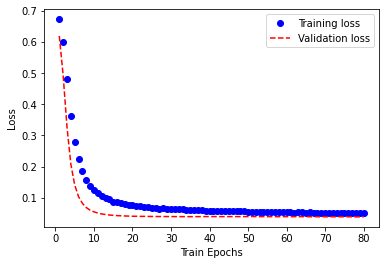

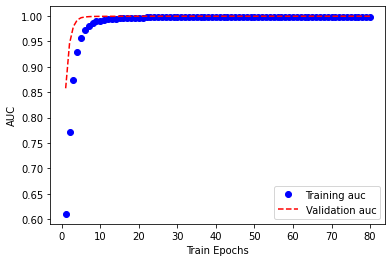

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

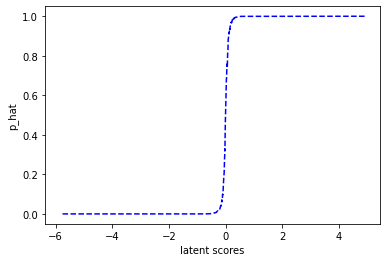

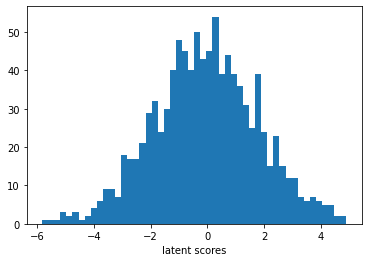

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

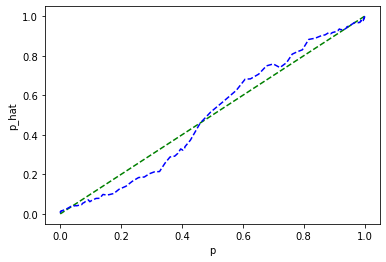

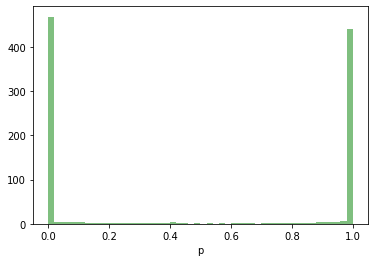

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

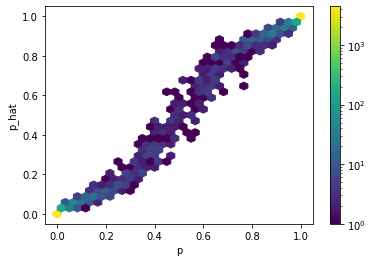

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

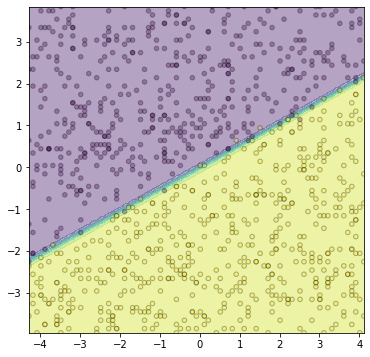

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 30)                330       
                                                                 
 dropout_72 (Dropout)        (None, 30)                0         
                                                                 
 dense_97 (Dense)            (None, 30)                930       
                                                                 
 dropout_73 (Dropout)        (None, 30)                0         
                                                                 
 dense_98 (Dense)            (None, 30)                930       
                                                                 
 dropout_74 (Dropout)        (None, 30)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.006,
 'batch': 256,
 'epoch': 59,
 'optimizer': 'sgd',
 'best_loss': {'loss': 0.03851069509983063, 'epoch': 80},
 'best_auc': {'auc': 0.9991437792778015, 'epoch': 80},
 'best_accuracy': {'accuracy': 0.9843999743461609, 'epoch': 75},
 'model': <keras.engine.sequential.Sequential at 0x7f1d3c463c70>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.04732473939657211, 'epoch': 41},
  'best_auc': {'auc': 0.998968243598938, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9815999865531921, 'epoch': 40}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.05085987597703934, 'epoch': 41},
  'best_auc': {'auc': 0.9989185333251953, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9814000129699707, 'epoch': 41}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.04070483520627022, 'epoch': 41},
  'best_auc': {'auc': 0.9990879893302917, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.983299970626831, 'epoch': 36}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 59,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.03967122733592987, 'epoch': 55},
  'best_auc': {'auc': 0.9991315007209778, 'epoch': 79},
  'best_accurac

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25